# Model Comparison


In [1]:
import DataLoader, Training, HelperFunctions, os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP

In [ ]:
# run exp on all three models

data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

for model_name in ["shallow", "deep", "eegnet"]:
    if model_name == "eegnet":
        lr = 0.03
    else:
        lr = 0.01
    for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
        df = DataLoader.load_df(data_path, task, preprocessing)
        data, labels = DataLoader.create_data_labels(df)
        Training.run_exp(data, labels, task, preprocessing, model_folder, model_name, 
                lr, n_epochs, n_splits, batch_size=64)

In [44]:
# run linear SVM

data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"

df_svm = pd.DataFrame()
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    data, labels = DataLoader.create_data_labels(df)
    #class_weights=class_weight.compute_class_weight('balanced',np.unique(labels),labels)
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(data, labels)
    svc = LinearSVC(class_weight="balanced")
    #svc = SVC(C=1, kernel='linear', class_weight="balanced")
    #csp = CSP(n_components=3)
    #clf = Pipeline([("StandardScaler",StandardScaler()), ('LinearSVC', svc)])
    clf = Pipeline([('LinearSVC', svc)])
    # memory too low for 10 jobs of MMN
    if task == "MMN":
        scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=5, scoring="balanced_accuracy")
    else:
        scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=10, scoring="balanced_accuracy")
    for score in scores:
        data = {'Task': task,
                'Model': "SVM",
                'Preprocessing': "medium",
                'Validation Balanced Accuracy': score}
        df_svm = df_svm.append(data, ignore_index=True)
    print(task+": "+str(np.mean(scores)))
df_path = os.getcwd()+"\\ModelComparison\\"
df_svm.to_csv(df_path+"df_svmERN.csv",index=False)

ERN: 0.7342981860023322


In [2]:
data_path = "F:/Masterthesis/Data/"
model_name = "eegnet"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["medium"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

,Task,Model,Preprocessing,Validation Balanced Accuracy
0,N170,eegnet,medium,0.774126
1,N400,eegnet,medium,0.759575
2,P3,eegnet,medium,0.746587
3,N2pc,eegnet,medium,0.662003
4,MMN,eegnet,medium,0.595574
...,...,...,...,...
16,P3,deep,medium,0.744658
17,N2pc,deep,medium,0.673445
18,MMN,deep,medium,0.597462
19,ERN,deep,medium,0.912473


In [4]:
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
    print(task, df_task[(df_task["Task"]==task) & (df_task["Model"]=="deep")].mean())

N170 Validation Balanced Accuracy    0.790905
dtype: float64
N400 Validation Balanced Accuracy    0.756642
dtype: float64
P3 Validation Balanced Accuracy    0.757549
dtype: float64
N2pc Validation Balanced Accuracy    0.677115
dtype: float64
MMN Validation Balanced Accuracy    0.599255
dtype: float64
ERN Validation Balanced Accuracy    0.907626
dtype: float64
LRP Validation Balanced Accuracy    0.816219
dtype: float64


In [4]:
df_path = os.getcwd()+"\\ModelComparison\\"
df_svm = pd.read_csv(df_path+"df_svm_medium.csv")
df_task = df_task.append(df_svm, ignore_index=True)
df_svm

,Model,Preprocessing,Task,Validation Balanced Accuracy
0,SVM,medium,N170,0.672922
1,SVM,medium,N170,0.672980
2,SVM,medium,N170,0.679681
3,SVM,medium,N170,0.689724
4,SVM,medium,N170,0.679934
...,...,...,...,...
65,SVM,medium,LRP,0.711257
66,SVM,medium,LRP,0.722944
67,SVM,medium,LRP,0.731091
68,SVM,medium,LRP,0.710907


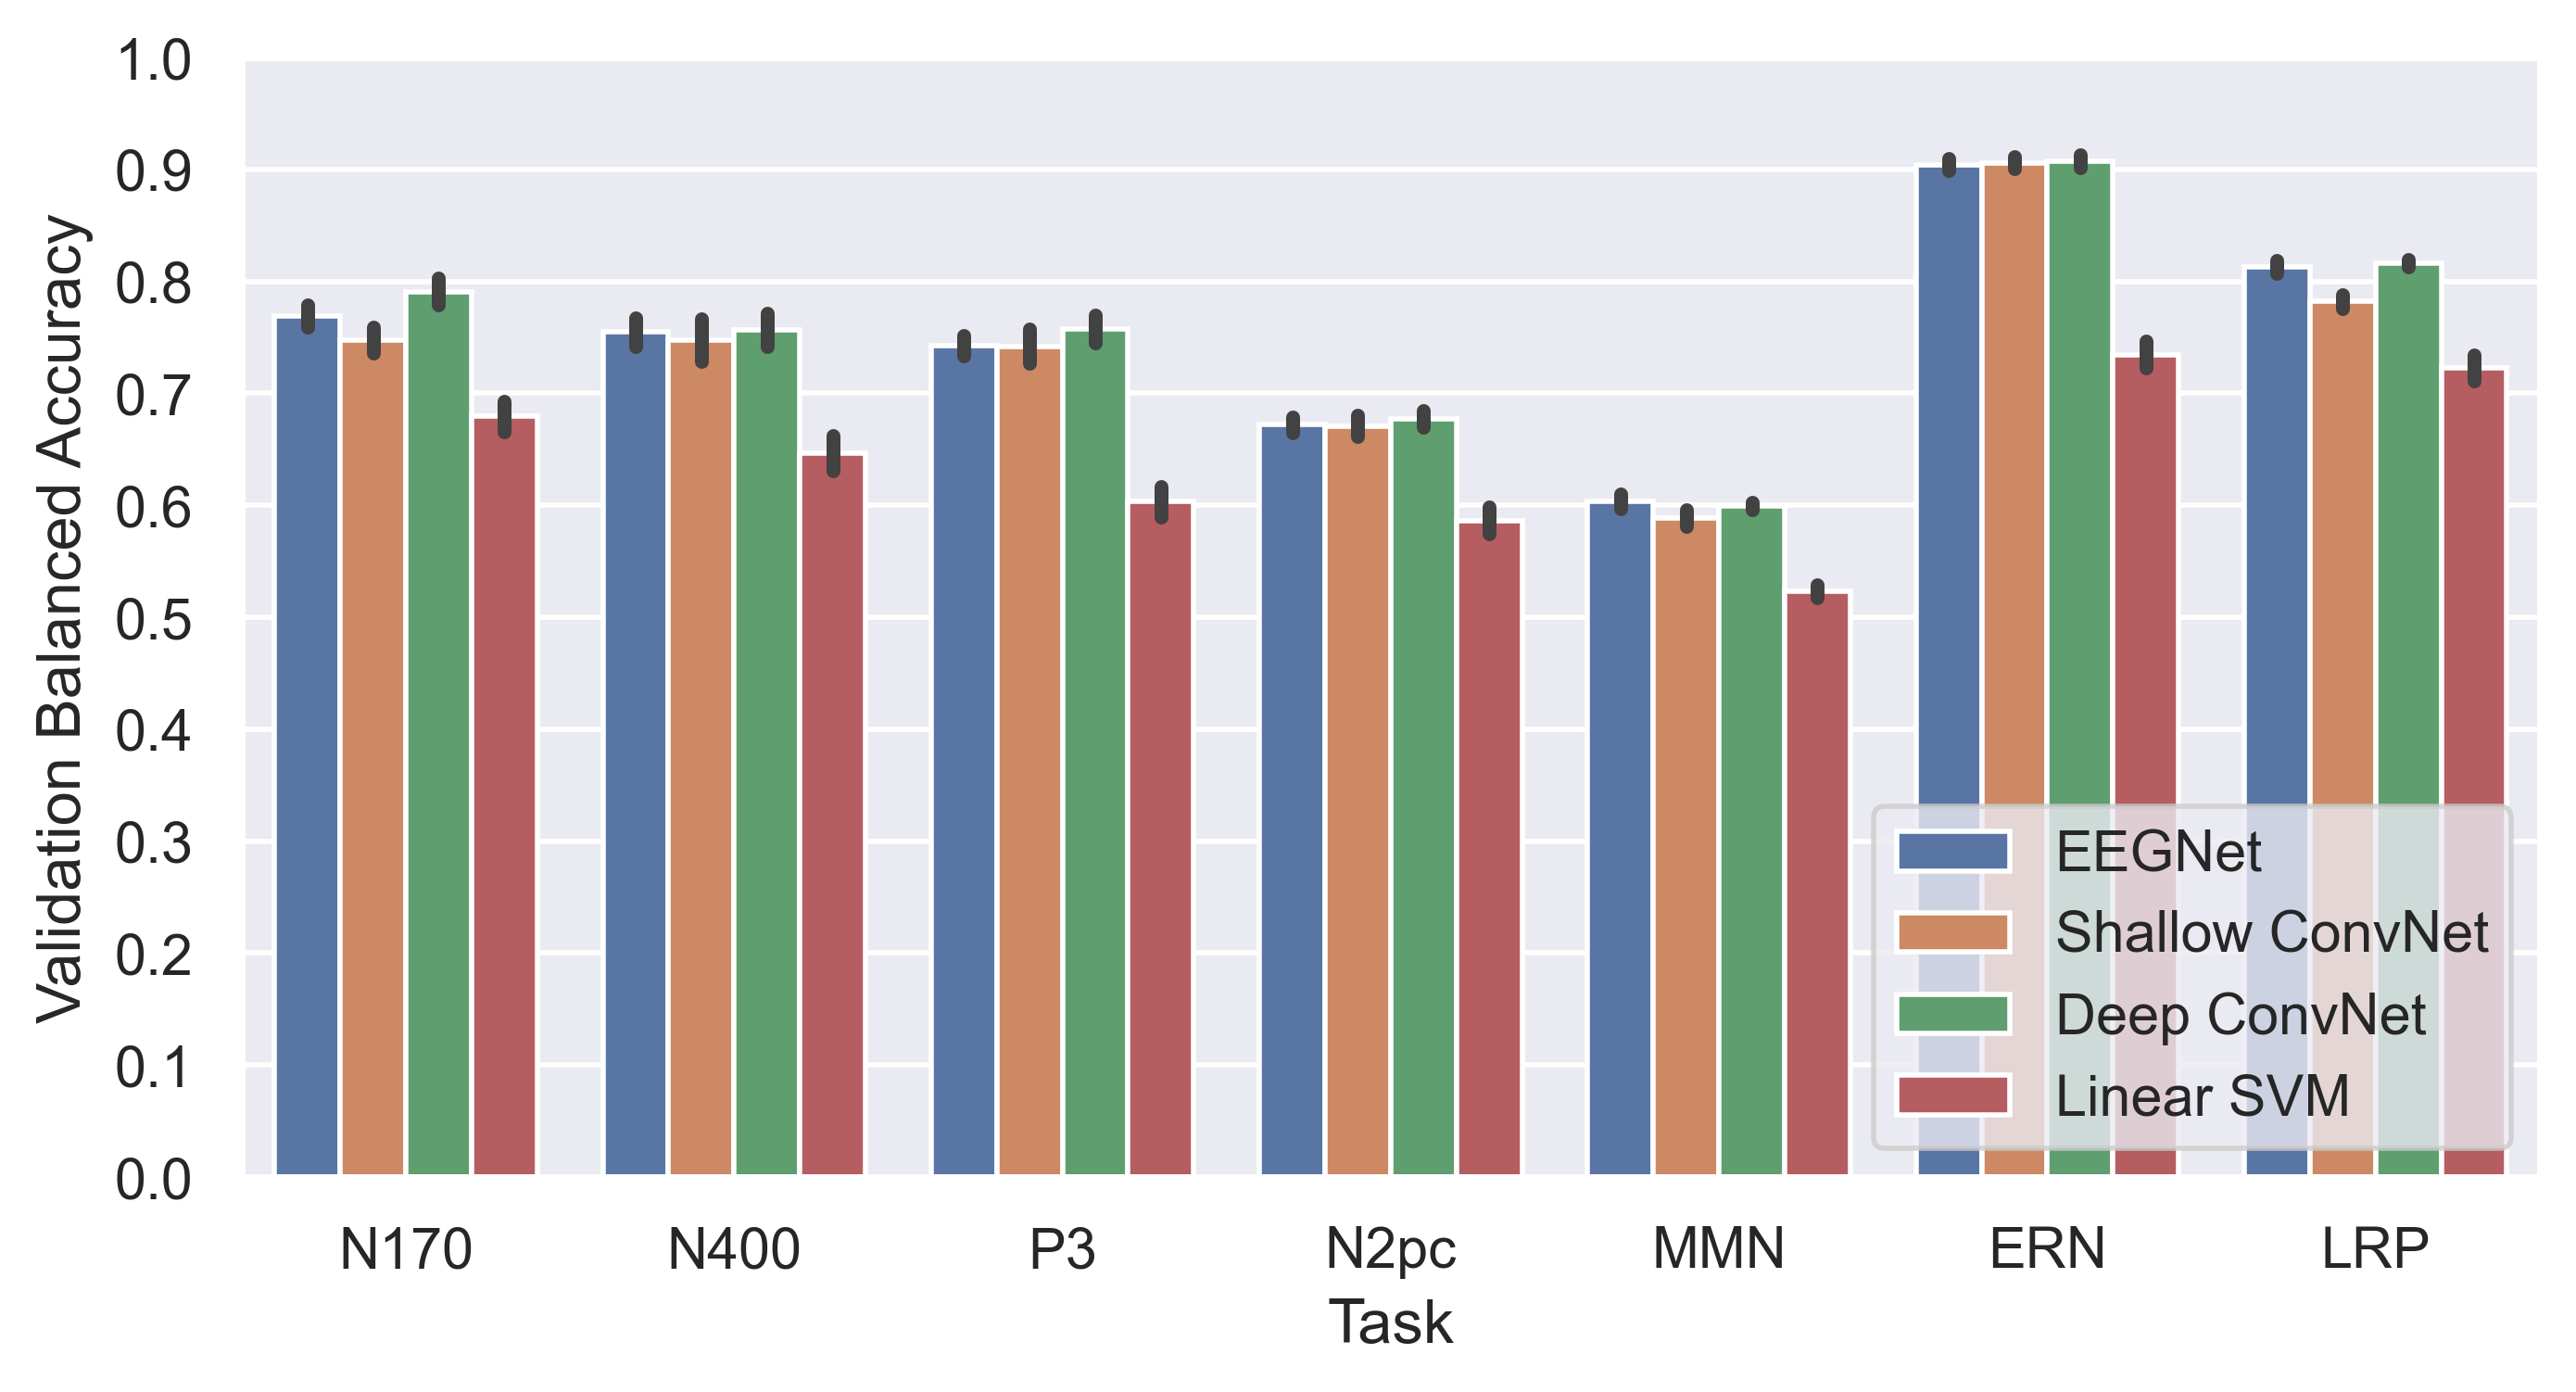

In [121]:
# plot accuracies for medium processing, all models
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Model", 
            data=df_task, ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right')
l.get_texts()[0].set_text('EEGNet')
l.get_texts()[1].set_text('Shallow ConvNet')
l.get_texts()[2].set_text('Deep ConvNet')
l.get_texts()[3].set_text('Linear SVM')

## Equal Sample Count

In [ ]:
# run exp on balanced subsets of the data

data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
n_epochs = 25
n_splits = 10
sample_count = 1000
model_folder = "ModelComparison_EqualSamples1000"

for model_name in ["shallow", "deep", "eegnet"]:
    if model_name == "eegnet":
        lr = 0.03
    else:
        lr = 0.01
    for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
        df = DataLoader.load_df(data_path, task, preprocessing)
        # lowest number of samples is P3 condition 0 with 1338 samples
        df = df.groupby(["condition"]).sample(sample_count, random_state=42)
        data, labels = DataLoader.create_data_labels(df)
        Training.run_exp(data, labels, task, preprocessing, model_folder, model_name, 
                lr, n_epochs, n_splits, batch_size=64)

In [41]:
# run exp on balanced subsets of the data for linear SVM

df_svm = pd.DataFrame()
for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
#for task in ["MMN"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    df = df.groupby(["condition"]).sample(sample_count, random_state=42)
    data, labels = DataLoader.create_data_labels(df)
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(data, labels)
    svc = LinearSVC(class_weight="balanced")
    clf = Pipeline([('LinearSVC', svc)])
    # memory issues
    #if task == "MMN":
    #    scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=5, scoring="balanced_accuracy")
    #else:
    scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=10, scoring="balanced_accuracy")
    for score in scores:
        data = {'Task': task,
                'Model': "SVM",
                'Preprocessing': "medium",
                'Validation Balanced Accuracy': score}
        df_svm = df_svm.append(data, ignore_index=True)
    print(task+": "+str(np.mean(scores)))
df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm.to_csv(df_path+"df_svm.csv",index=False)

N170: 0.66875
N400: 0.65075
P3: 0.6285000000000001
N2pc: 0.5820000000000001
MMN: 0.5305
ERN: 0.80525
LRP: 0.725


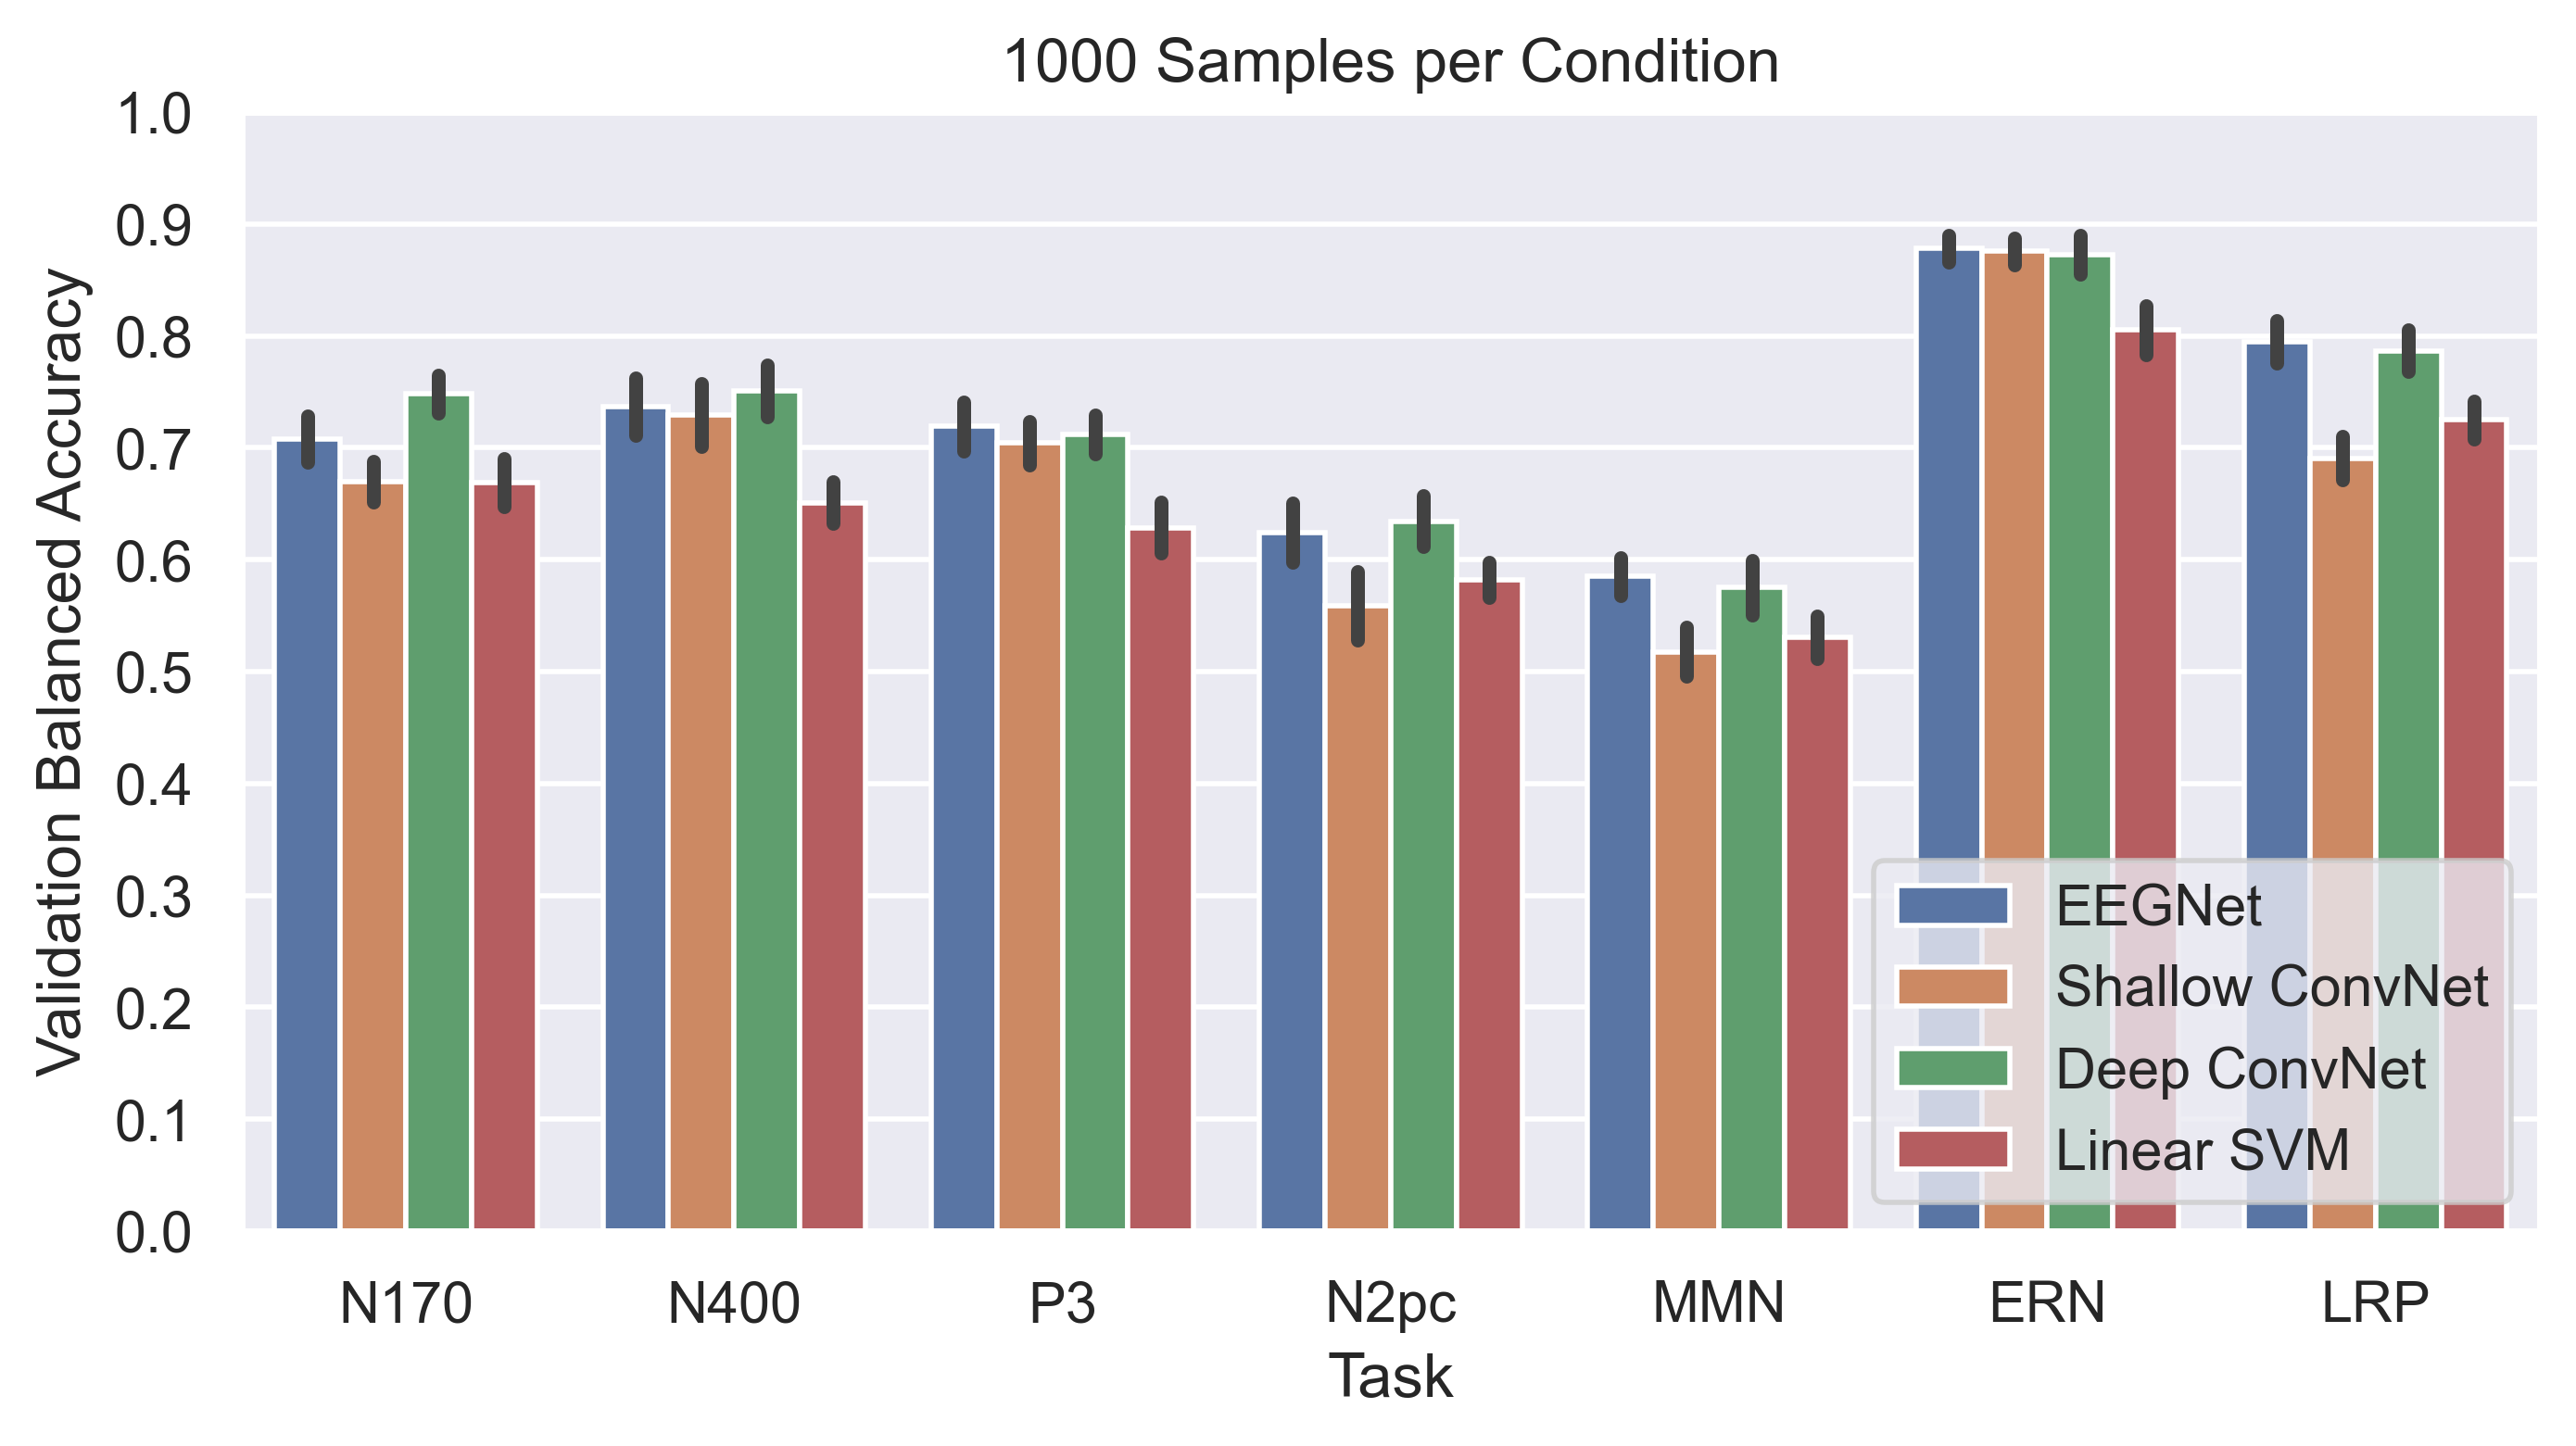

In [122]:
# Load data for 1000 samples and plot

data_path = "F:/Masterthesis/Data/"
model_name = "eegnet"
model_folder = "ModelComparison_EqualSamples1000"
n_epochs = 25
n_splits = 10

# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["medium"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm = pd.read_csv(df_path+"df_svm.csv")
df_task = df_task.append(df_svm, ignore_index=True)

# N170 plot, no downsampling
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
plt.title("1000 Samples per Condition")
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Model", 
            data=df_task, ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right')
l.get_texts()[0].set_text('EEGNet')
l.get_texts()[1].set_text('Shallow ConvNet')
l.get_texts()[2].set_text('Deep ConvNet')
l.get_texts()[3].set_text('Linear SVM')

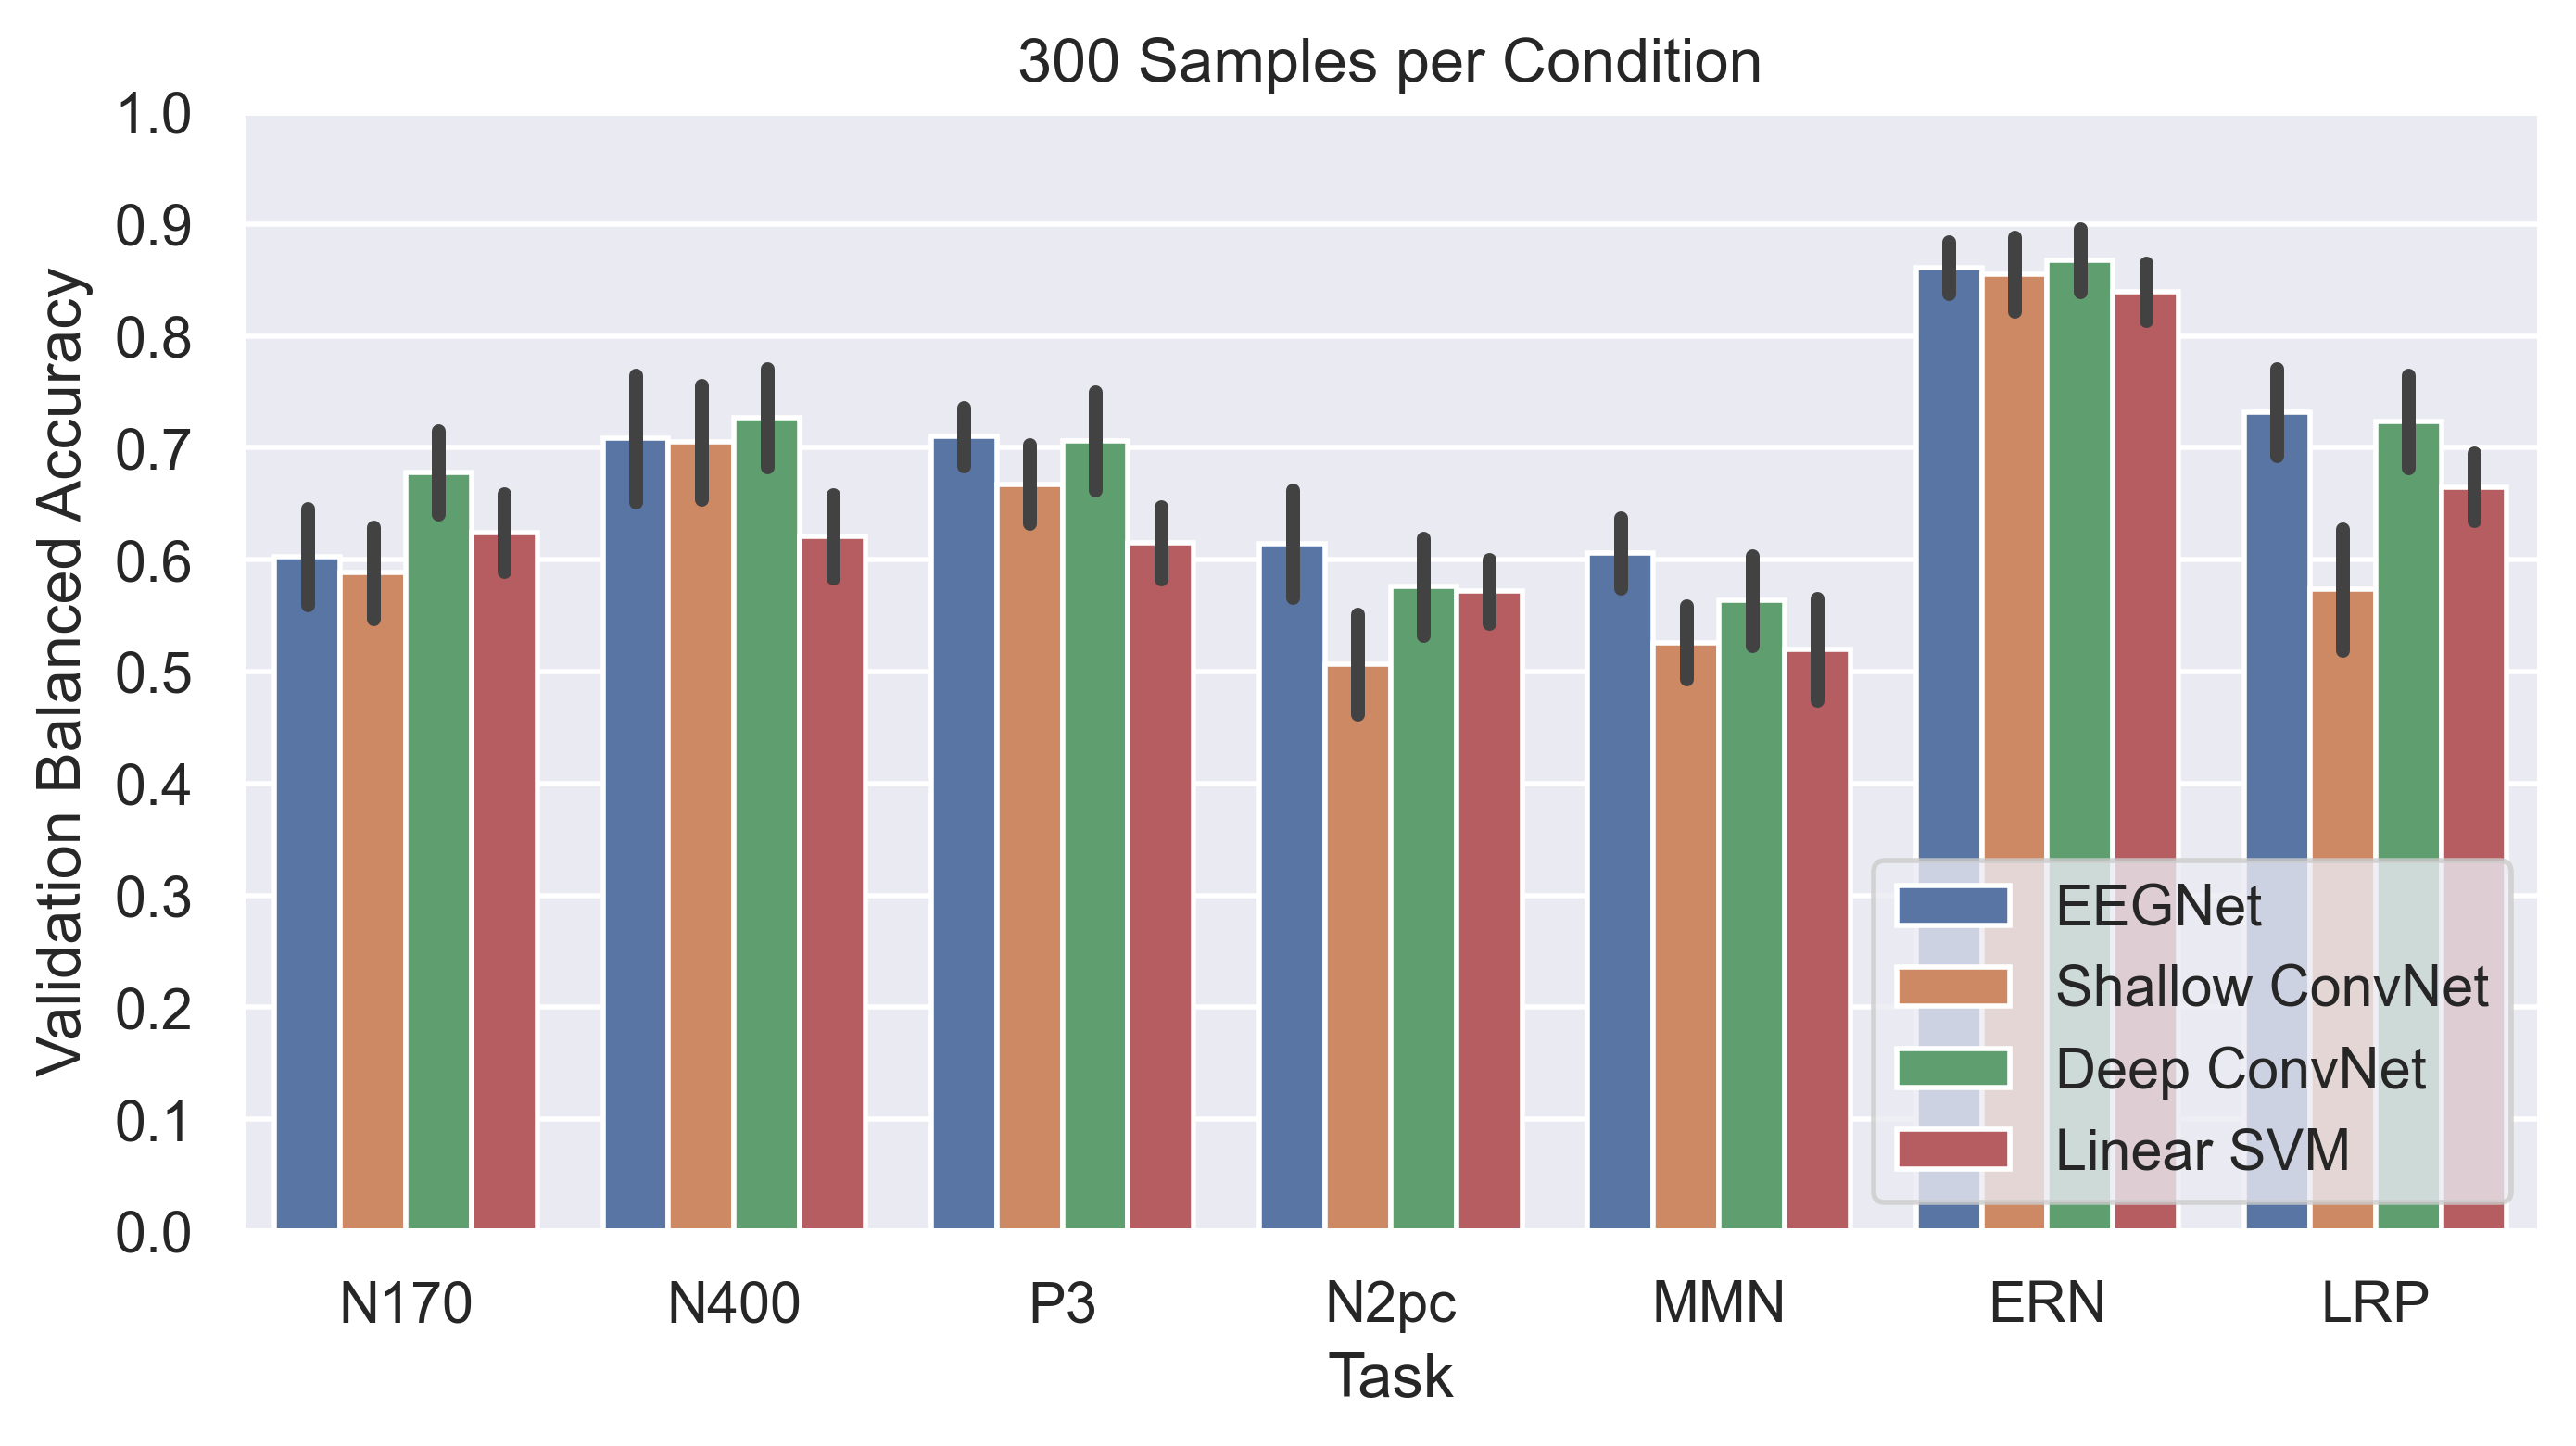

In [123]:
# Load data for 300 samples and plot

data_path = "F:/Masterthesis/Data/"
model_name = "eegnet"
model_folder = "ModelComparison_EqualSamples300"
n_epochs = 25
n_splits = 10

# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["medium"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm = pd.read_csv(df_path+"df_svm.csv")
df_task = df_task.append(df_svm, ignore_index=True)

# N170 plot, no downsampling
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
plt.title("300 Samples per Condition")
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Model", 
            data=df_task, ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right')
l.get_texts()[0].set_text('EEGNet')
l.get_texts()[1].set_text('Shallow ConvNet')
l.get_texts()[2].set_text('Deep ConvNet')
l.get_texts()[3].set_text('Linear SVM')

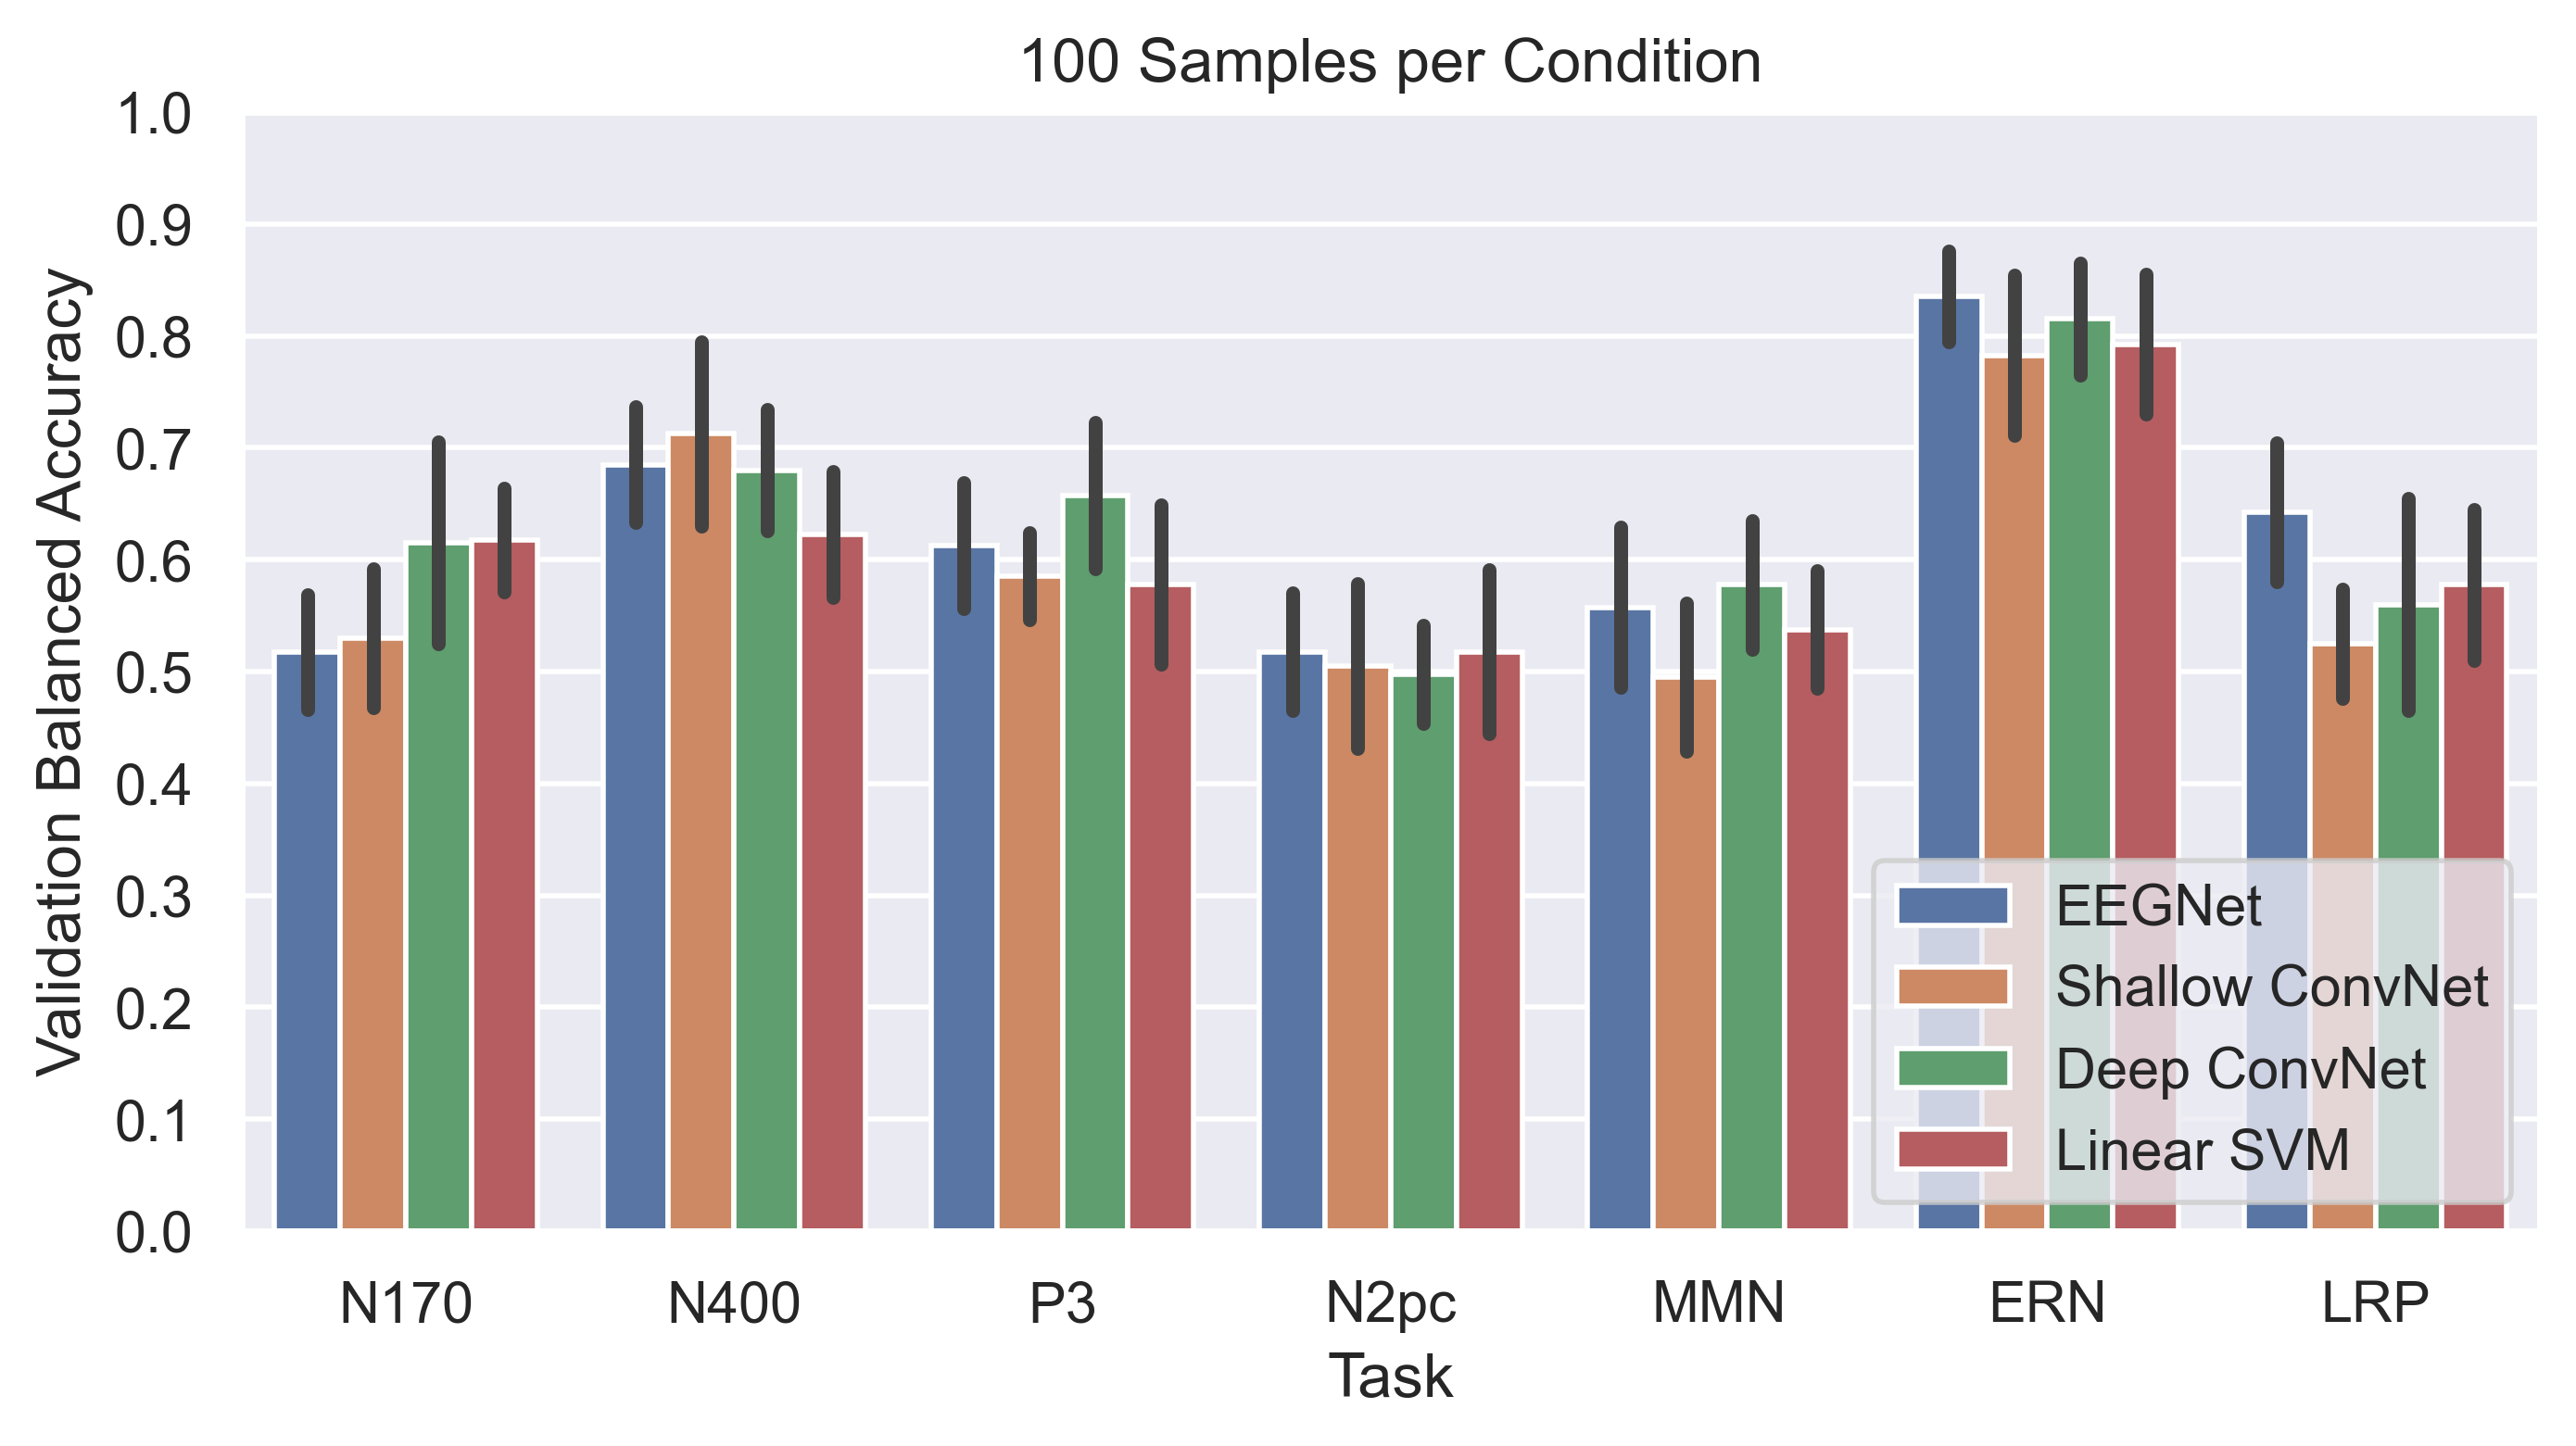

In [125]:
# Load data for 100 samples and plot

data_path = "F:/Masterthesis/Data/"
model_name = "eegnet"
model_folder = "ModelComparison_EqualSamples100"
n_epochs = 25
n_splits = 10

# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["medium"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm = pd.read_csv(df_path+"df_svm.csv")
df_task = df_task.append(df_svm, ignore_index=True)

# N170 plot, no downsampling
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4), dpi=400)
plt.title("100 Samples per Condition")
g = sns.barplot(x="Task", y="Validation Balanced Accuracy", 
            hue="Model", 
            data=df_task, ci="sd")
g.set_yticks(np.round(np.arange(0,1.1,0.1),1))
l = plt.legend(loc='lower right')
l.get_texts()[0].set_text('EEGNet')
l.get_texts()[1].set_text('Shallow ConvNet')
l.get_texts()[2].set_text('Deep ConvNet')
l.get_texts()[3].set_text('Linear SVM')

In [7]:
# Load data for all sample counts and models

data_path = "F:/Masterthesis/Data/"
model_name = "eegnet"
n_epochs = 25
n_splits = 10

df_list = []

# Get Results
for samples in ["200", "600", "2000", "All"]:
    if samples == "200":
        model_folder = "ModelComparison_EqualSamples100"
    elif samples == "600":
        model_folder = "ModelComparison_EqualSamples300"
    elif samples == "2000":
        model_folder = "ModelComparison_EqualSamples1000"
    else:
        model_folder = "ModelComparison"
    results = []
    for model_name in ["eegnet","shallow","deep"]:
        for preprocessing in ["medium"]:
            for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
                df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
                df["Model"] = model_name
                df["Preprocessing"] = preprocessing
                df["Task"] = task
                results.append(df.iloc[-1])
    df_results = pd.concat(results, axis=1)
    df_results = df_results.transpose().reset_index()
    # Put results in correct dataframe for seaborn plot
    df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
    df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
    list = []
    for i in range(3,13):
        list.append(df_task.iloc[:,[0,1,2,i]])
    df_task = pd.concat(list, axis=0)
    df_path = os.getcwd()+"\\"+model_folder+"\\"
    df_svm = pd.read_csv(df_path+"df_svm.csv")
    df_task = df_task.append(df_svm, ignore_index=True)
    df_task["Sample Count"] = samples
    df_list.append(df_task)
df_task = pd.concat(df_list, axis=0)

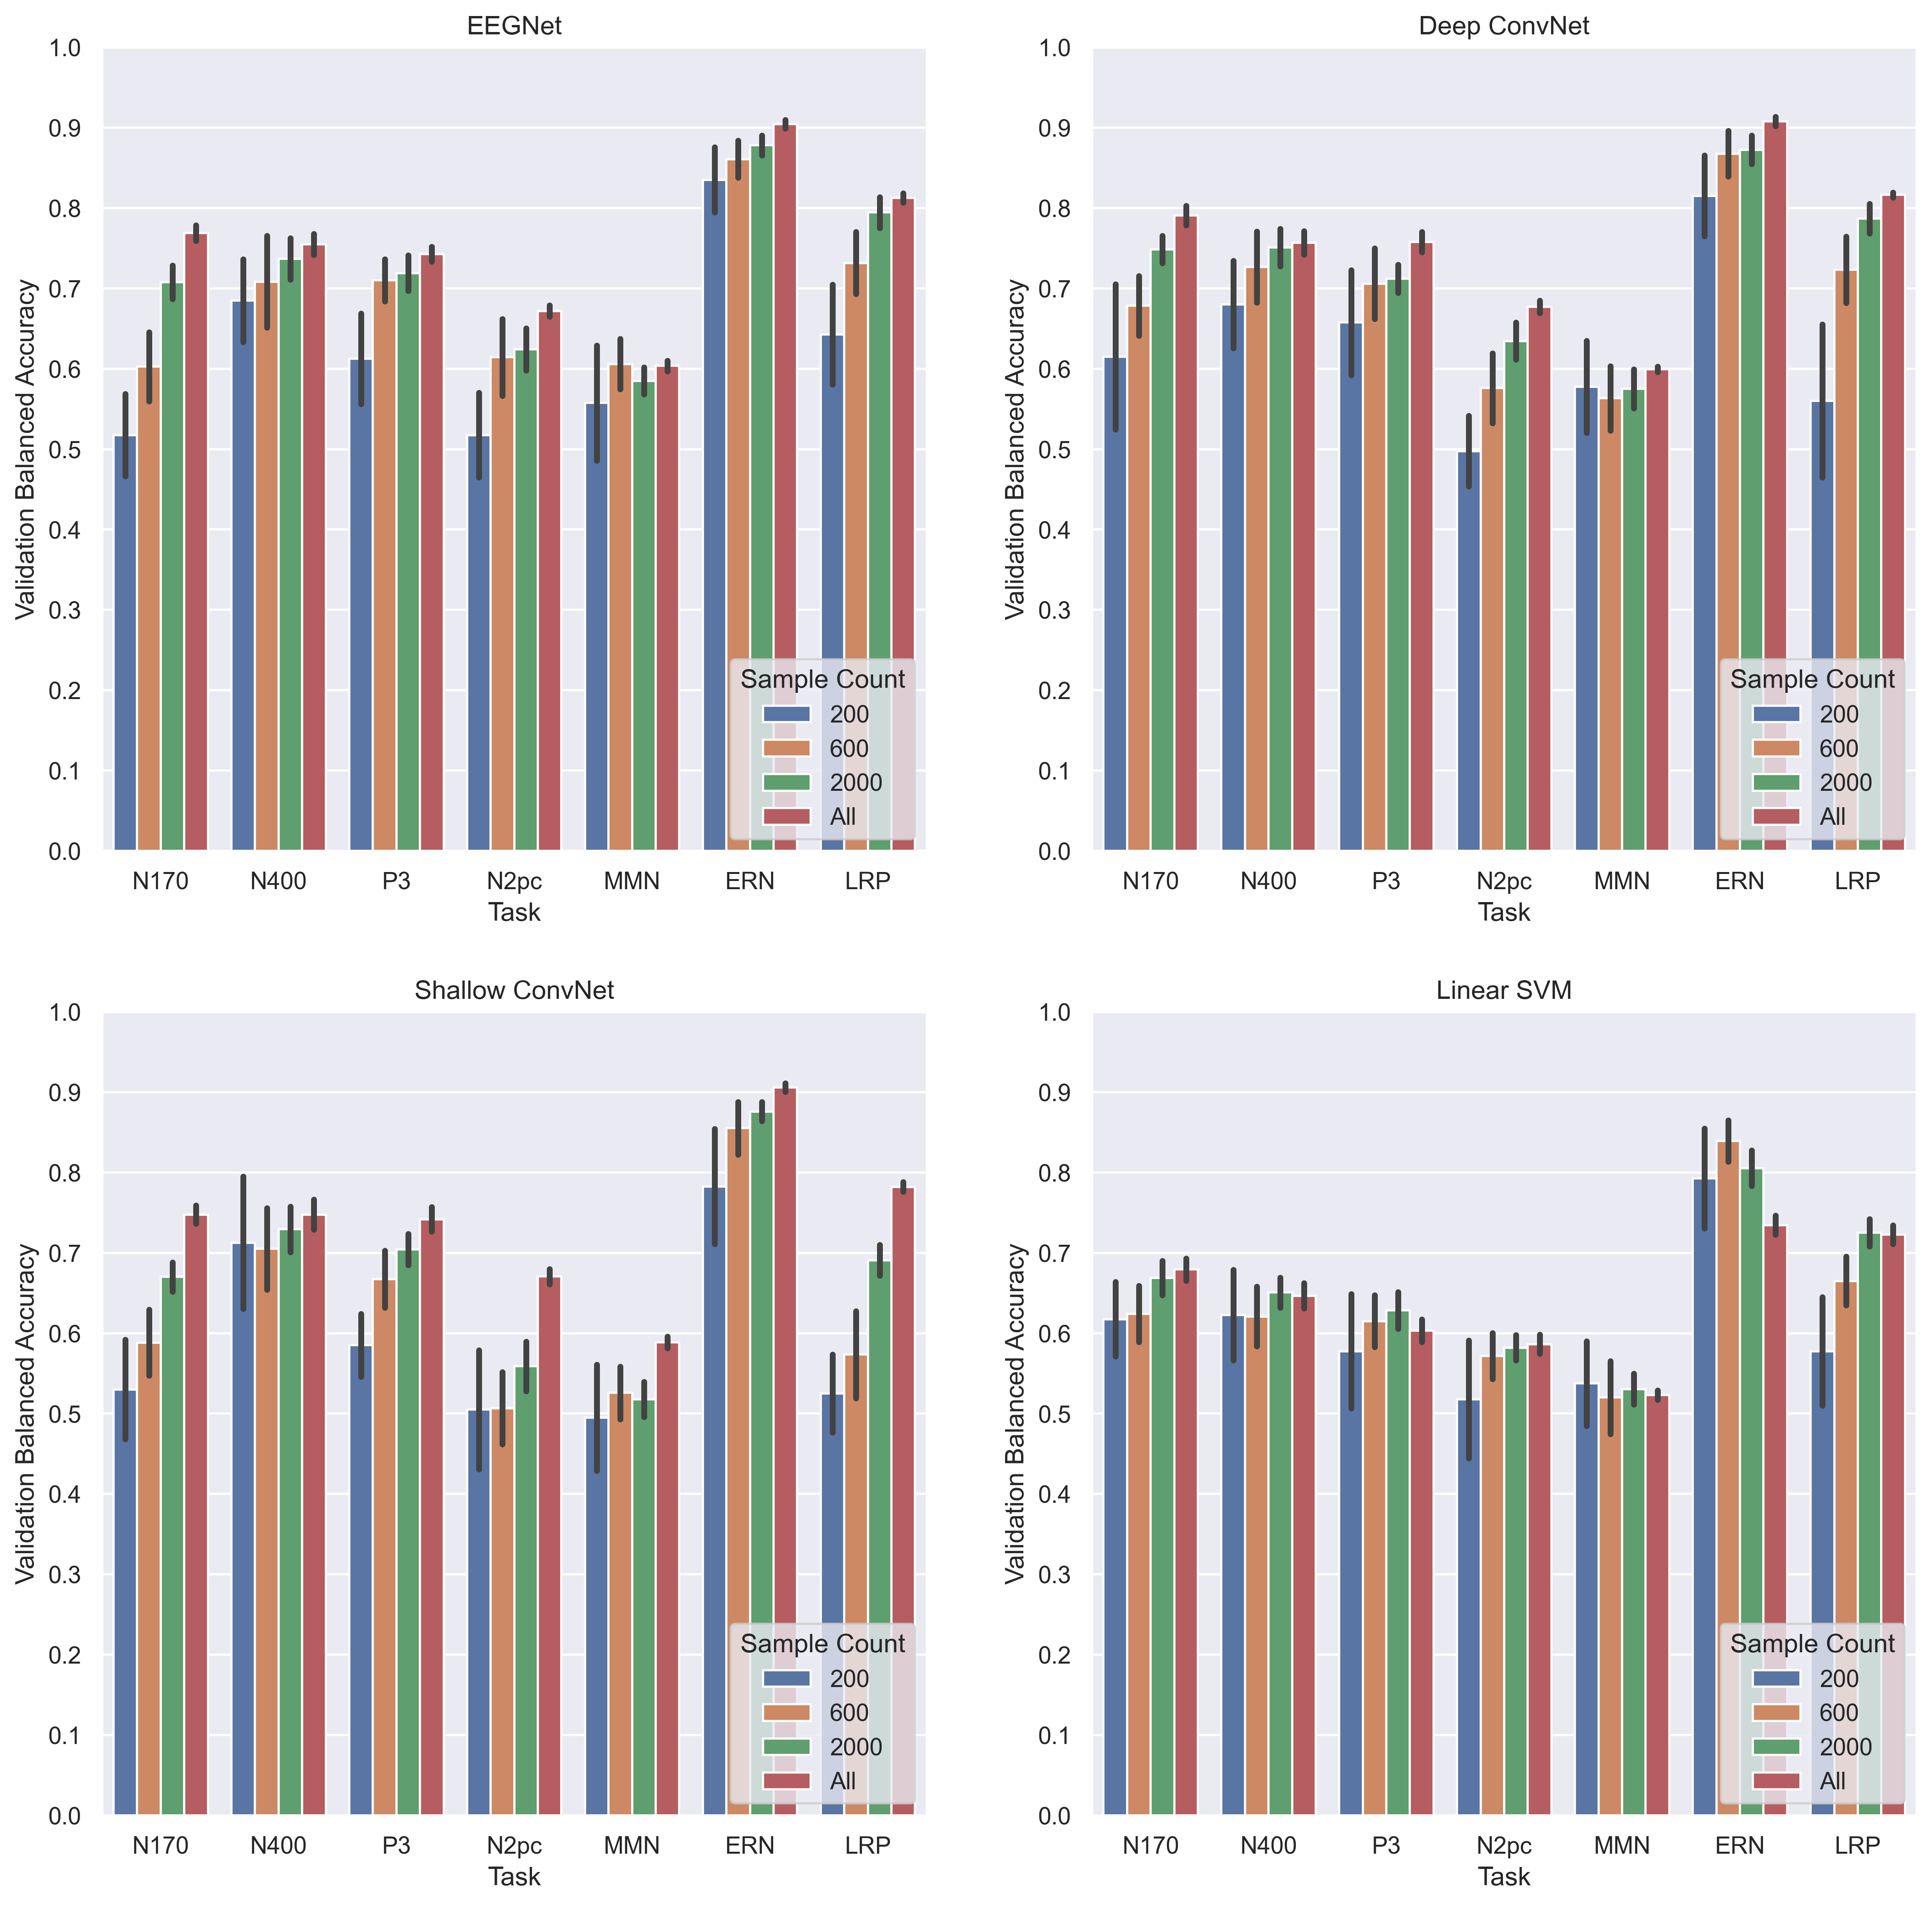

In [8]:
# plot all sample counts and models

sns.set(style="darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=400)
#axes[0,0].title("EEGNet")
sns.barplot(ax=axes[0,0], x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="eegnet"], ci="sd")
axes[0,0].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[0,0].set_title("EEGNet")
axes[0,0].legend(title="Sample Count", loc='lower right');

sns.barplot(ax=axes[0,1], x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="deep"], ci="sd")
axes[0,1].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[0,1].set_title("Deep ConvNet")
axes[0,1].legend(title="Sample Count", loc='lower right');

sns.barplot(ax=axes[1,0], x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="shallow"], ci="sd")
axes[1,0].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[1,0].set_title("Shallow ConvNet")
axes[1,0].legend(title="Sample Count", loc='lower right');

sns.barplot(ax=axes[1,1], x="Task", y="Validation Balanced Accuracy", 
            hue="Sample Count", 
            data=df_task[df_task["Model"]=="SVM"], ci="sd")
axes[1,1].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[1,1].set_title("Linear SVM")
axes[1,1].legend(title="Sample Count", loc='lower right');

# Preprocessing

In [8]:
# quick check of how many sample per task for medium preprocessing


data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

for task in ["N170", "N400", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    print(task,df.shape[0])

N170 5781
N400 3443
N2pc 10826
MMN 39232
ERN 16048
LRP 16048


In [7]:
# quick check of how many sample per task for heavy preprocessing

data_path = "F:/Masterthesis/Data/"
preprocessing = "heavy"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

for task in ["N170", "N400", "N2pc", "MMN", "ERN", "LRP"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    print(task,df.shape[0])

N170 5603
N400 3341
N2pc 9429
MMN 35733
ERN 13559
LRP 13985


In [ ]:
# run exp for different preprocessing levels

data_path = "F:/Masterthesis/Data/"
preprocessing = "heavy"
model_folder = "ModelComparison"
n_epochs = 25
n_splits = 10

for model_name in ["shallow", "deep", "eegnet"]:
    if model_name == "eegnet":
        lr = 0.03
    else:
        lr = 0.01
    for task in ["N170", "N400", "N2pc", "MMN", "ERN", "LRP"]:
        df = DataLoader.load_df(data_path, task, preprocessing)
        data, labels = DataLoader.create_data_labels(df)
        Training.run_exp(data, labels, task, preprocessing, model_folder, model_name, 
                lr, n_epochs, n_splits, batch_size=64)

In [6]:
# run exp for different preprocessing levels for linear svm

data_path = "F:/Masterthesis/Data/"
model_folder = "ModelComparison"
preprocessing = "light"

df_svm = pd.DataFrame()
for task in ["MMN"]:
    df = DataLoader.load_df(data_path, task, preprocessing)
    #df = df.groupby(["condition"]).sample(1000, random_state=42)
    data, labels = DataLoader.create_data_labels(df)
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(data, labels)
    svc = LinearSVC(class_weight="balanced")
    clf = Pipeline([('LinearSVC', svc)])
    # memory issues
    if task == "MMN":
        scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=4, scoring="balanced_accuracy")
    else:
        scores = cross_val_score(clf, data.reshape(-1, 30*251), labels, cv=cv, n_jobs=10, scoring="balanced_accuracy")
    for score in scores:
        data = {'Task': task,
                'Model': "SVM",
                'Preprocessing': "medium",
                'Validation Balanced Accuracy': score}
        df_svm = df_svm.append(data, ignore_index=True)
    print(task+": "+str(np.mean(scores)))
df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm.to_csv(df_path+"df_svm_light4.csv",index=False)

MMN: 0.5246995519942148


In [9]:
# Get Results
results = []
for model_name in ["eegnet","shallow","deep"]:
    for preprocessing in ["light","medium","heavy"]:
        for task in ["N170", "N400", "P3", "N2pc", "MMN", "ERN", "LRP"]:
            df = Training.load_exp(model_folder, model_name, task, preprocessing, n_splits)
            df["Model"] = model_name
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,13):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)
df_task

,Task,Model,Preprocessing,Validation Balanced Accuracy
0,N170,eegnet,light,0.774922
1,N400,eegnet,light,0.756639
2,P3,eegnet,light,0.746711
3,N2pc,eegnet,light,0.673269
4,MMN,eegnet,light,0.593513
...,...,...,...,...
58,P3,deep,heavy,0.767723
59,N2pc,deep,heavy,0.66442
60,MMN,deep,heavy,0.585673
61,ERN,deep,heavy,0.892489


In [10]:
# append svm results

df_path = os.getcwd()+"\\"+model_folder+"\\"
df_svm = pd.read_csv(df_path+"df_svm_light.csv")
df_task = df_task.append(df_svm, ignore_index=True)
df_svm = pd.read_csv(df_path+"df_svm_medium.csv")
df_task = df_task.append(df_svm, ignore_index=True)
df_svm = pd.read_csv(df_path+"df_svm_heavy.csv")
df_task = df_task.append(df_svm, ignore_index=True)

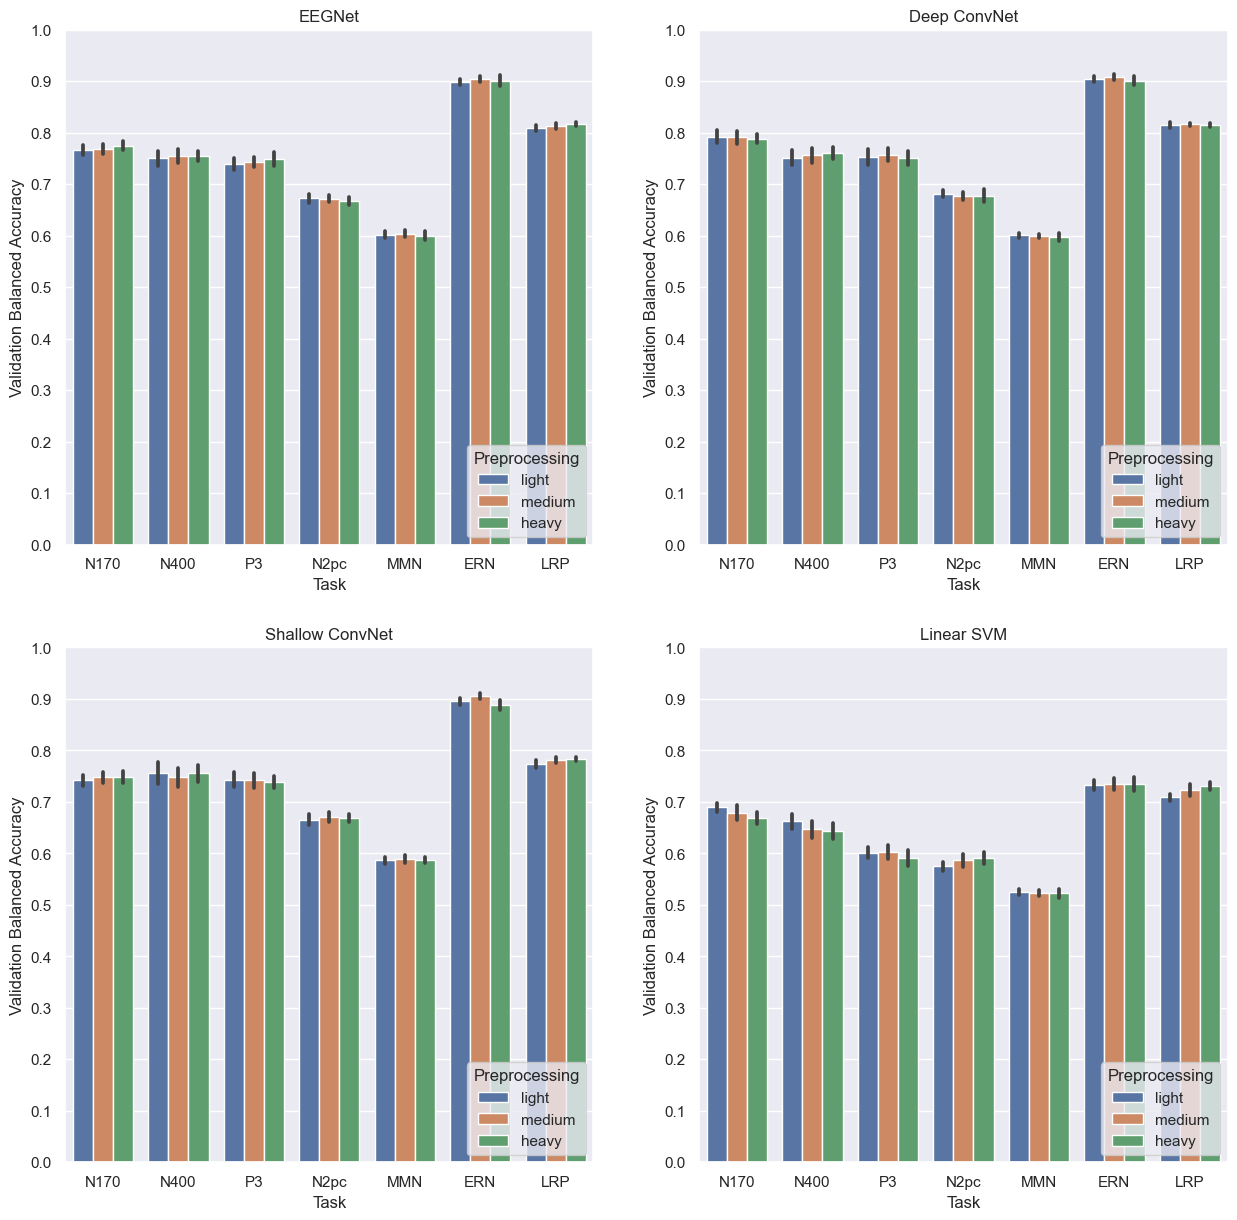

In [11]:
# plot preprocessing for all models

sns.set(style="darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=100)
#axes[0,0].title("EEGNet")
sns.barplot(ax=axes[0,0], x="Task", y="Validation Balanced Accuracy", 
            hue="Preprocessing", 
            data=df_task[df_task["Model"]=="eegnet"], ci="sd")
axes[0,0].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[0,0].set_title("EEGNet")
axes[0,0].legend(title="Preprocessing", loc='lower right');

sns.barplot(ax=axes[0,1], x="Task", y="Validation Balanced Accuracy", 
            hue="Preprocessing", 
            data=df_task[df_task["Model"]=="deep"], ci="sd")
axes[0,1].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[0,1].set_title("Deep ConvNet")
axes[0,1].legend(title="Preprocessing", loc='lower right');

sns.barplot(ax=axes[1,0], x="Task", y="Validation Balanced Accuracy", 
            hue="Preprocessing", 
            data=df_task[df_task["Model"]=="shallow"], ci="sd")
axes[1,0].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[1,0].set_title("Shallow ConvNet")
axes[1,0].legend(title="Preprocessing", loc='lower right');

sns.barplot(ax=axes[1,1], x="Task", y="Validation Balanced Accuracy", 
            hue="Preprocessing", 
            data=df_task[df_task["Model"]=="SVM"], ci="sd")
axes[1,1].set_yticks(np.round(np.arange(0,1.1,0.1),1))
axes[1,1].set_title("Linear SVM")
axes[1,1].legend(title="Preprocessing", loc='lower right');